In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [52]:
# setting current directory
%cd /content/drive/My\ Drive

/content/drive/My Drive


### Importing libraries

In [53]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [54]:
# importing libraries
from fastai.vision import *
from fastai.metrics import *
from fastai.callbacks import *

### Setting path and batch-size

In [55]:
# setting batch size
bs = 64

In [56]:
# setting path of dataset
path =Path('Multiclass-classification-5-vehical-classes')
path

PosixPath('Multiclass-classification-5-vehical-classes')

In [57]:
path.ls()

[PosixPath('Multiclass-classification-5-vehical-classes/test_actual_labels.csv'),
 PosixPath('Multiclass-classification-5-vehical-classes/labels.csv'),
 PosixPath('Multiclass-classification-5-vehical-classes/test'),
 PosixPath('Multiclass-classification-5-vehical-classes/train'),
 PosixPath('Multiclass-classification-5-vehical-classes/models'),
 PosixPath('Multiclass-classification-5-vehical-classes/Multi_class.ipynb')]

### Data Augmentation and creating image databunch

In [58]:
# data augmentation
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [59]:
data=ImageDataBunch.from_csv(path,folder='train',csv_labels='labels.csv',test='test',seed=1,valid_pct=0.2, ds_tfms=tfms, size=224,bs=bs).normalize(imagenet_stats)

In [60]:
data

ImageDataBunch;

Train: LabelList (4000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bicycle,Bicycle,Bicycle,Bicycle,Bicycle
Path: Multiclass-classification-5-vehical-classes;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bus,Motorcycle,Car,Car,Bus
Path: Multiclass-classification-5-vehical-classes;

Test: LabelList (788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Multiclass-classification-5-vehical-classes

In [ ]:
x,y = data.train_ds[3]
x,y

(Image (3, 224, 224), Category 0)

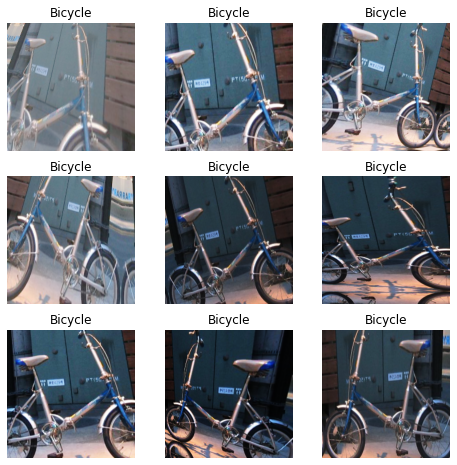

In [ ]:
# plotting image grid of transformed images 
def _plot(i,j,ax):
    x,y = data.train_ds[200]
    x.show(ax, y=y)

plot_multi(_plot,3,3, figsize=(8,8))

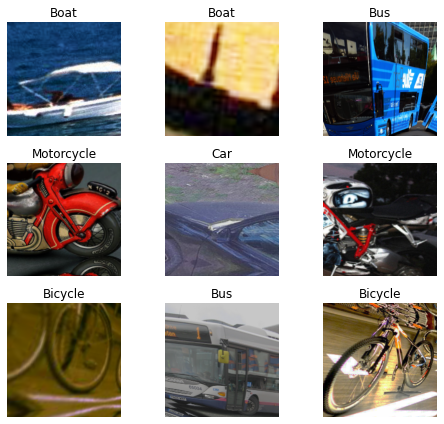

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

In [ ]:
# printing no of classes in our dataset
print(data.classes)
len(data.classes),data.c

['Bicycle', 'Boat', 'Bus', 'Car', 'Motorcycle']


(5, 5)

### Training: resnet34

In [61]:
# creating learner object using pretrained resnet34 architecture
learn_resnet34 = cnn_learner(data, models.resnet34, metrics=[error_rate,accuracy])

In [62]:
# layers of resnet34 which are freezed
learn_resnet34.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# layers at the end of model corresponding to our dataset
learn_resnet34.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=5, bias=True)
)

In [ ]:
# summary of model
learn_resnet34.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

#### finding optimum learning rate and training model with 10 epochs

In [ ]:
# finding optimum learning rate by lr finder
learn_resnet34.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


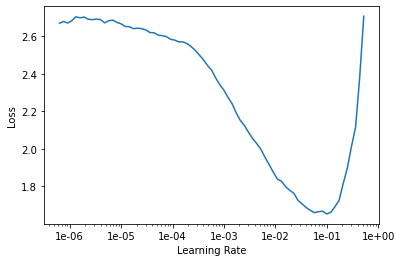

In [ ]:
learn_resnet34.recorder.plot()

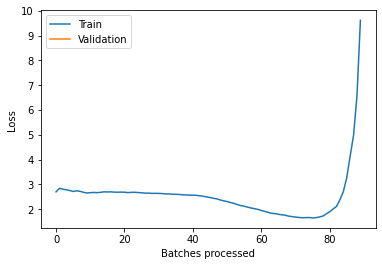

In [ ]:
learn_resnet34.recorder.plot_losses()

In [63]:
# train for 10 epochs (10 cycles through all our data and save best model in terms of accuracy using callbacks
learn_resnet34.fit_one_cycle(10,max_lr=1e-02,callbacks=[SaveModelCallback(learn_resnet34,every="improvement",monitor='accuracy',name='best')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.821892,0.319306,0.090000,0.910000,05:03
1,0.612643,0.350554,0.106000,0.894000,05:04
2,0.570903,0.757716,0.195000,0.805000,05:01
3,0.532200,0.308660,0.096000,0.904000,05:02
4,0.470257,0.285748,0.100000,0.900000,05:02
5,0.410700,0.247130,0.088000,0.912000,05:03
6,0.369901,0.203429,0.069000,0.931000,05:05
7,0.326045,0.192296,0.066000,0.934000,05:01
8,0.275460,0.173750,0.062000,0.938000,04:55
9,0.254256,0.162179,0.058000,0.942000,04:54


Better model found at epoch 0 with accuracy value: 0.9100000262260437.
Better model found at epoch 5 with accuracy value: 0.9120000004768372.
Better model found at epoch 6 with accuracy value: 0.9309999942779541.
Better model found at epoch 7 with accuracy value: 0.9340000152587891.
Better model found at epoch 8 with accuracy value: 0.9380000233650208.
Better model found at epoch 9 with accuracy value: 0.9419999718666077.


#### Interpretations

In [65]:
# Interpretations
interp = ClassificationInterpretation.from_learner(learn_resnet34)

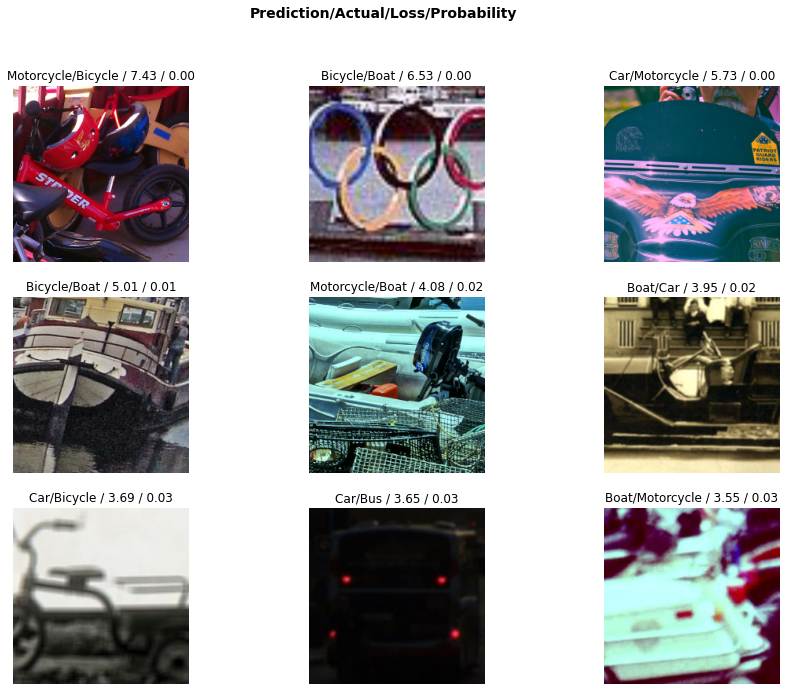

In [66]:
# plotting images contributing to top losses
interp.plot_top_losses(9,figsize=(15,11))

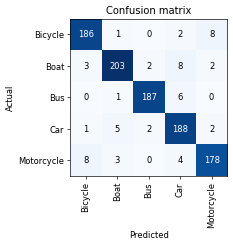

In [67]:
# plotting confusion matrix
interp.plot_confusion_matrix(dpi=60)

In [68]:
interp.most_confused(min_val=2)

[('Bicycle', 'Motorcycle', 8),
 ('Boat', 'Car', 8),
 ('Motorcycle', 'Bicycle', 8),
 ('Bus', 'Car', 6),
 ('Car', 'Boat', 5),
 ('Motorcycle', 'Car', 4),
 ('Boat', 'Bicycle', 3),
 ('Motorcycle', 'Boat', 3),
 ('Bicycle', 'Car', 2),
 ('Boat', 'Bus', 2),
 ('Boat', 'Motorcycle', 2),
 ('Car', 'Bus', 2),
 ('Car', 'Motorcycle', 2)]

#### loading best model and unfreezing all layers of model for fine-tuning and saving best model using callback

In [94]:
learn_resnet34.load('best')

Learner(data=ImageDataBunch;

Train: LabelList (4000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bicycle,Bicycle,Bicycle,Bicycle,Bicycle
Path: Multiclass-classification-5-vehical-classes;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bus,Motorcycle,Car,Car,Bus
Path: Multiclass-classification-5-vehical-classes;

Test: LabelList (788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Multiclass-classification-5-vehical-classes, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_

In [95]:
# unfreezing and training model with different learning rates i.e. initial layers are trained with small learning rate because we don't want to change them more
learn_resnet34.unfreeze()
learn_resnet34.fit_one_cycle(10, max_lr=slice(1e-4,1e-2),callbacks=[SaveModelCallback(learn_resnet34,every="improvement",monitor='accuracy',name='best_finetuned')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.326834,0.373971,0.098000,0.902000,05:00
1,0.430703,0.631695,0.174000,0.826000,04:55
2,0.539489,0.786471,0.232000,0.768000,04:43
3,0.496713,0.735126,0.196000,0.804000,04:43
4,0.445628,0.288616,0.098000,0.902000,04:47
5,0.416562,0.313549,0.104000,0.896000,04:50
6,0.341679,0.198173,0.067000,0.933000,04:49
7,0.302419,0.210608,0.072000,0.928000,04:52
8,0.249976,0.189287,0.062000,0.938000,04:52
9,0.220439,0.185200,0.063000,0.937000,04:50


Better model found at epoch 0 with accuracy value: 0.9020000100135803.
Better model found at epoch 6 with accuracy value: 0.9330000281333923.
Better model found at epoch 8 with accuracy value: 0.9380000233650208.


### hyperparameter optimization

In [ ]:
!pip install bayesian-optimization

In [ ]:
def fit_with(lr,wd,dp):
    
    # Create the model using a specified dropout and weight decay
    learn = cnn_learner(data, models.resnet34, metrics=accuracy, ps=dp)
    
    
    # Train the model for a specified number of epochs using a specified max learning rate
    learn.fit_one_cycle(1, max_lr=lr)
    
    # Plot the loss over time
    learn.recorder.plot_losses()
    
    # Save, print, and return the model's accuracy
    acc = float(learn.validate(learn.data.valid_dl)[1])
    
    print("Accuracy:" + str(acc*100))
    
    # The small change: we're only going to return the accuracy
    
    return acc

In [ ]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'lr': (1e-4, 1e-2), 'wd':(1e-4,0.4), 'dp':(0.1,0.5)}

optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=2, n_iter=2,)



for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

### prediction using resnet34

In [96]:
# loading best model as it is giving highest accuracy
learn_resnet34.load('best')

Learner(data=ImageDataBunch;

Train: LabelList (4000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bicycle,Bicycle,Bicycle,Bicycle,Bicycle
Path: Multiclass-classification-5-vehical-classes;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bus,Motorcycle,Car,Car,Bus
Path: Multiclass-classification-5-vehical-classes;

Test: LabelList (788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Multiclass-classification-5-vehical-classes, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_

In [97]:
# predicting on single image by renet34 model
img=data.test_ds[0][0]
p=learn_resnet34.predict(img)
print(int(p[0]))
print(str(p[0]))

0
Bicycle


In [98]:
# predicting on all test images using resnet34
from tqdm import tqdm
pred=[]
images=[]
pred_s=[]
for i in tqdm(range(len(data.test_ds))):
  image=str(data.test_ds.items[i]).split('/')[-1]
  images.append(image)
  p=learn_resnet34.predict(data.test_ds[i][0])
  pred.append(int(p[0]))
  pred_s.append(str(p[0]))

100%|██████████| 788/788 [03:48<00:00,  3.45it/s]


In [99]:
# saving test image name, predicted value and class name in dataframe
df=pd.DataFrame(list(zip(images,pred,pred_s)),columns=['image_name','pred_value','pred_class'])

In [100]:
df.head()

,image_name,pred_value,pred_class
0,001271_09.jpg,0,Bicycle
1,001254_10.jpg,0,Bicycle
2,001178_05.jpg,0,Bicycle
3,001201_19.jpg,0,Bicycle
4,001259_18.jpg,0,Bicycle


In [101]:
# loading actual classes of test images
df_a=pd.read_csv('/content/drive/My Drive/Multiclass-classification-5-vehical-classes/test_actual_labels.csv')

In [102]:
df_a.head()

,image_name,tags
0,001178_05.jpg,Bicycle
1,001184_08.jpg,Bicycle
2,001188_03.jpg,Bicycle
3,001195_05.jpg,Bicycle
4,001201_19.jpg,Bicycle


In [103]:
# merging actual and predicted values of test images
result_resnet34= pd.merge (df_a,df,on='image_name')

In [118]:
result_resnet34.head()

,image_name,tags,pred_value,pred_class
0,001178_05.jpg,Bicycle,0,Bicycle
1,001184_08.jpg,Bicycle,4,Motorcycle
2,001188_03.jpg,Bicycle,0,Bicycle
3,001195_05.jpg,Bicycle,0,Bicycle
4,001201_19.jpg,Bicycle,0,Bicycle


In [105]:
# saving results in csv file
result_resnet34.to_csv('/content/drive/My Drive/Multiclass-classification-5-vehical-classes/result_resnet34.csv')

### Extra work: using Imagecleaner to delete images which are having top losses

the widget will not delete images directly from disk but it will create a new csv file cleaned.csv from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In [74]:
# In order to clean the entire set of images, we need to create a new dataset without the split. 
db=ImageDataBunch.from_csv(path,folder='train',csv_labels='labels.csv',test='test',seed=1,valid_pct=0, ds_tfms=tfms, size=224,bs=bs).normalize(imagenet_stats)

In [75]:
db

ImageDataBunch;

Train: LabelList (5000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bicycle,Bicycle,Bicycle,Bicycle,Bicycle
Path: Multiclass-classification-5-vehical-classes;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: Multiclass-classification-5-vehical-classes;

Test: LabelList (788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Multiclass-classification-5-vehical-classes

In [76]:
# Then we create a new learner to use our new databunch with all the images.
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('best');

In [77]:
s, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [78]:
s,idxs

(LabelList (5000 items)
 x: ImageList
 Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
 y: CategoryList
 Bicycle,Bicycle,Bicycle,Bicycle,Bicycle
 Path: Multiclass-classification-5-vehical-classes,
 tensor([ 157, 1160, 4388,  ..., 2463, 2753, 2809]))

In [80]:
# ImageCleaner will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.ImageCleaner(ds, idxs)
ImageCleaner(s, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [87]:
# recreate the databunch and learn_cln from the cleaned.csv file
data_c=ImageDataBunch.from_csv(path,csv_labels='cleaned.csv',test='test',seed=1,valid_pct=0.2, ds_tfms=tfms, size=224,bs=bs).normalize(imagenet_stats)

In [88]:
data_c

ImageDataBunch;

Train: LabelList (3957 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bicycle,Bicycle,Bicycle,Bicycle,Bicycle
Path: Multiclass-classification-5-vehical-classes;

Valid: LabelList (989 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bus,Car,Car,Motorcycle,Bicycle
Path: Multiclass-classification-5-vehical-classes;

Test: LabelList (788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Multiclass-classification-5-vehical-classes

In [89]:
# creating new lwarner object from cleaned dataset
learn_resnet34_c = cnn_learner(data_c, models.resnet34, metrics=[error_rate,accuracy])

In [90]:
# finding optimum learning rate by lr finder
learn_resnet34_c.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


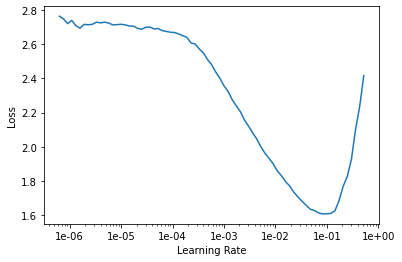

In [91]:
learn_resnet34_c.recorder.plot()

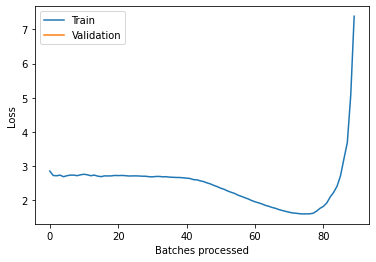

In [92]:
learn_resnet34_c.recorder.plot_losses()

we can now train model on our new cleaned data

### Training model with Resnet50

In [106]:
learn_resnet50 = cnn_learner(data, models.resnet50, metrics=[error_rate,accuracy])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [107]:
learn_resnet50.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


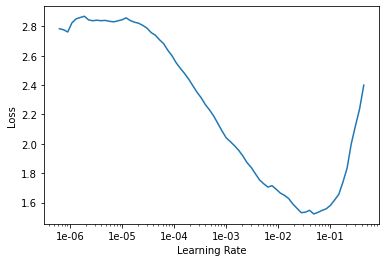

In [108]:
learn_resnet50.recorder.plot()

In [109]:
learn_resnet50.fit_one_cycle(10, max_lr=slice(1e-2),callbacks=[SaveModelCallback(learn_resnet50,every="improvement",monitor='accuracy',name='best_resnet50')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.708136,0.275086,0.078000,0.922000,05:06
1,0.551677,0.255415,0.078000,0.922000,05:09
2,0.506583,0.224036,0.066000,0.934000,04:57
3,0.441359,0.242498,0.063000,0.937000,05:00
4,0.382589,0.195373,0.061000,0.939000,04:59
5,0.327966,0.159905,0.048000,0.952000,05:11
6,0.260073,0.154916,0.047000,0.953000,05:15
7,0.233084,0.147407,0.045000,0.955000,05:14
8,0.205510,0.135732,0.039000,0.961000,05:14
9,0.190710,0.133158,0.040000,0.960000,05:13


Better model found at epoch 0 with accuracy value: 0.921999990940094.
Better model found at epoch 2 with accuracy value: 0.9340000152587891.
Better model found at epoch 3 with accuracy value: 0.9369999766349792.
Better model found at epoch 4 with accuracy value: 0.9390000104904175.
Better model found at epoch 5 with accuracy value: 0.9520000219345093.
Better model found at epoch 6 with accuracy value: 0.953000009059906.
Better model found at epoch 7 with accuracy value: 0.9549999833106995.
Better model found at epoch 8 with accuracy value: 0.9610000252723694.


#### unfrezzing and fine tuning using discriminative learning rates

In [110]:
learn_resnet50.unfreeze()

In [111]:
# fine tuning model
learn_resnet50.fit_one_cycle(10, max_lr=slice(1e-4,1e-2),callbacks=[SaveModelCallback(learn_resnet50,every="improvement",monitor='accuracy',name='best_resnet50_finetuned')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.328888,0.464103,0.117000,0.883000,05:22
1,0.427710,0.431036,0.126000,0.874000,05:22
2,0.522612,0.554192,0.149000,0.851000,05:22
3,0.502362,0.302282,0.116000,0.884000,05:23
4,0.434502,0.404199,0.124000,0.876000,05:22
5,0.395443,0.236011,0.089000,0.911000,05:25
6,0.341917,0.217623,0.075000,0.925000,05:28
7,0.276578,0.177660,0.058000,0.942000,05:22
8,0.217189,0.153795,0.055000,0.945000,05:15
9,0.181816,0.156399,0.058000,0.942000,05:15


Better model found at epoch 0 with accuracy value: 0.8830000162124634.
Better model found at epoch 3 with accuracy value: 0.8840000033378601.
Better model found at epoch 5 with accuracy value: 0.9110000133514404.
Better model found at epoch 6 with accuracy value: 0.925000011920929.
Better model found at epoch 7 with accuracy value: 0.9419999718666077.
Better model found at epoch 8 with accuracy value: 0.9449999928474426.


#### predictions using resnet50

In [112]:
# loading best load saved with pretrained layers freezed as accuracy from that is higher
learn_resnet50.load('best_resnet50')

Learner(data=ImageDataBunch;

Train: LabelList (4000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bicycle,Bicycle,Bicycle,Bicycle,Bicycle
Path: Multiclass-classification-5-vehical-classes;

Valid: LabelList (1000 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Bus,Motorcycle,Car,Car,Bus
Path: Multiclass-classification-5-vehical-classes;

Test: LabelList (788 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: Multiclass-classification-5-vehical-classes, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_

In [113]:
# predicting on all test images by resnet50
from tqdm import tqdm
pred=[]
images=[]
pred_s=[]
for i in tqdm(range(len(data.test_ds))):
  image=str(data.test_ds.items[i]).split('/')[-1]
  images.append(image)
  p=learn_resnet50.predict(data.test_ds[i][0])
  pred.append(int(p[0]))
  pred_s.append(str(p[0]))

100%|██████████| 788/788 [01:12<00:00, 10.82it/s]


In [114]:
# saving test image name, predicted value and class name in dataframe
df_50=pd.DataFrame(list(zip(images,pred,pred_s)),columns=['image_name','pred_value','pred_class'])

In [115]:
# merging actual and predicted values of test images
result_resnet50= pd.merge (df_a,df_50,on='image_name')

In [116]:
result_resnet50.head()

,image_name,tags,pred_value,pred_class
0,001178_05.jpg,Bicycle,0,Bicycle
1,001184_08.jpg,Bicycle,0,Bicycle
2,001188_03.jpg,Bicycle,0,Bicycle
3,001195_05.jpg,Bicycle,0,Bicycle
4,001201_19.jpg,Bicycle,0,Bicycle


In [117]:
# saving results in csv file
result_resnet50.to_csv('/content/drive/My Drive/Multiclass-classification-5-vehical-classes/result_resnet50.csv')